# Mlflow가 없다면??
<img width="1382" alt="image" src="https://user-images.githubusercontent.com/63439911/200203199-e41121e7-bfc4-4dc4-bf63-42156aa6d0da.png">



In [93]:
import torch.nn as nn
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
import mlflow 
import warnings
import random
import matplotlib.pyplot as plt
import copy

# Seed 고정


In [74]:
def seed_everything(seed):
    torch.manual_seed(seed) # torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) # cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True # 딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) # numpy를 사용할 경우 고정
    random.seed(seed) # 파이썬 자체 모듈 random 모듈의 시드 고정

seed = 42

seed_everything(seed)

# Model 정의

In [75]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784,100) # MNIST 데이터셋이 28*28로 총 784개의 픽셀로 이루어져있기 때문에 784를 입력 크기로 넣음.
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100,100)
        self.fc3 = nn.Linear(100,10)

    def forward(self, x):
        x1 = self.fc1(x)
        x2 = self.relu(x1)
        x3 = self.fc2(x2)
        x4 = self.relu(x3)
        x5 = self.fc3(x4)

        return x5

In [123]:
class Net1(nn.Module):
    
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(784,100) # MNIST 데이터셋이 28*28로 총 784개의 픽셀로 이루어져있기 때문에 784를 입력 크기로 넣음.
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100,10)

    def forward(self, x):
        x1 = self.fc1(x)
        x2 = self.relu(x1)
        x3 = self.fc2(x2)

        return x3

In [119]:
Net()

Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [124]:
Net1()

Net1(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

# Dataset 정의  
## MNIST Dataset을 사용하여 학습,검증을 합니다.

In [125]:
download_root = 'MNIST_data/'

train_dataset = datasets.MNIST(root=download_root,
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)
                         
test_dataset = datasets.MNIST(root=download_root,
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)    

In [ ]:
train_dataset[0][0].resize(1,784)


In [126]:
print('학습 데이터 수 : ',len(train_dataset))
print('테스트 데이터 수 :',len(test_dataset))

학습 데이터 수 :  60000
테스트 데이터 수 : 10000


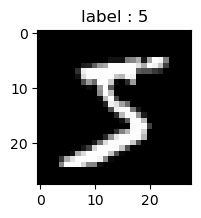

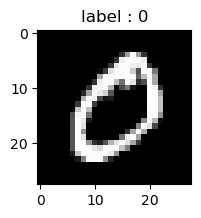

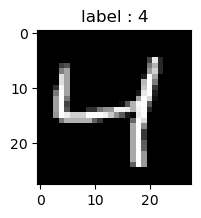

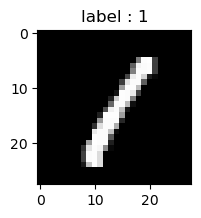

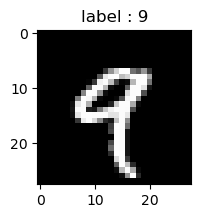

In [127]:

for i in range(5):

    image, label = train_dataset[i]

    plt.figure(figsize=(2,2))
    plt.imshow(image.squeeze().numpy(),'gray')
    plt.title('label : %s' % label)
    plt.show()

# Batch_size, Train, Test Dataloader 정의

In [128]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# 하이퍼 파라미터 정의

![image](https://user-images.githubusercontent.com/63439911/200167296-d804d2f3-1b16-40df-ac1b-191afb16d1e0.png)

In [131]:
model = Net()
loss_function = nn.CrossEntropyLoss() # 실제 정답과 예측값의 차이를 수치화해주는 함수.
learning_rate = 0.001 # AdamW:0.001, SGD:0.1, Adam:0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # loss_function을 최소화 하는 모델의 파라미터를 찾는 방법.
epochs = 10

In [161]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec

input_example = np.array([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118,
         0.0706, 0.0706, 0.0706, 0.4941, 0.5333, 0.6863, 0.1020, 0.6510, 1.0000,
         0.9686, 0.4980, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1176, 0.1412, 0.3686, 0.6039,
         0.6667, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.8824, 0.6745, 0.9922,
         0.9490, 0.7647, 0.2510, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1922, 0.9333, 0.9922, 0.9922,
         0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.9843, 0.3647, 0.3216,
         0.3216, 0.2196, 0.1529, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0706, 0.8588, 0.9922,
         0.9922, 0.9922, 0.9922, 0.9922, 0.7765, 0.7137, 0.9686, 0.9451, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3137,
         0.6118, 0.4196, 0.9922, 0.9922, 0.8039, 0.0431, 0.0000, 0.1686, 0.6039,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0549, 0.0039, 0.6039, 0.9922, 0.3529, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.5451, 0.9922, 0.7451, 0.0078, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0431, 0.7451, 0.9922, 0.2745,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1373, 0.9451,
         0.8824, 0.6275, 0.4235, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.3176, 0.9412, 0.9922, 0.9922, 0.4667, 0.0980, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.1765, 0.7294, 0.9922, 0.9922, 0.5882, 0.1059, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0627, 0.3647, 0.9882, 0.9922, 0.7333,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9765, 0.9922,
         0.9765, 0.2510, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1804, 0.5098, 0.7176, 0.9922,
         0.9922, 0.8118, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.1529, 0.5804, 0.8980, 0.9922, 0.9922,
         0.9922, 0.9804, 0.7137, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0941, 0.4471, 0.8667, 0.9922, 0.9922, 0.9922,
         0.9922, 0.7882, 0.3059, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0902, 0.2588, 0.8353, 0.9922, 0.9922, 0.9922, 0.9922,
         0.7765, 0.3176, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0706, 0.6706, 0.8588, 0.9922, 0.9922, 0.9922, 0.9922, 0.7647,
         0.3137, 0.0353, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.2157, 0.6745, 0.8863, 0.9922, 0.9922, 0.9922, 0.9922, 0.9569, 0.5216,
         0.0431, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.5333, 0.9922, 0.9922, 0.9922, 0.8314, 0.5294, 0.5176, 0.0627,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]],dtype=np.float32)

input_schema = Schema([
    TensorSpec(np.dtype(np.float32),(1,784))
])

output_schema = Schema([
    TensorSpec(np.dtype(np.float32),(-1,10))
])

signature = ModelSignature(inputs=input_schema,outputs=output_schema)

# MLflow를 활용하여 학습진행

![image](https://user-images.githubusercontent.com/63439911/200745460-99a6268d-cd4e-4334-ab10-2c0de356c4c5.png)


In [162]:
warnings.filterwarnings(action='ignore')
experiment_name = '혼돈의 AIP' # 실험명, 실험관리를 용이하게 해줍니다. 


if not mlflow.get_experiment_by_name(experiment_name): 
  mlflow.create_experiment(name=experiment_name)
experiment = mlflow.get_experiment_by_name(experiment_name)

mlflow.set_tracking_uri('http://127.0.0.1:5000') # 로컬 서버에 실행을 기록하기 위해 함수 호출


best_accuracy = 0
model.zero_grad()

with mlflow.start_run(experiment_id=experiment.experiment_id,run_name="boom"):
  for epoch in range(epochs):
    
    model.train() # 학습
    train_accuracy = 0
    train_loss = 0

    for images, labels in train_loader:
      images = images.reshape(batch_size,784)
      image = model(images)
      loss = loss_function(image,labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      prediction = torch.argmax(image,1)
      correct = (prediction == labels)
      train_accuracy+= correct.sum().item() / len(train_dataset)
      train_loss += loss.item() / len(train_loader)

    model.eval() # 평가
    val_accuracy = 0
    val_loss = 0

    for images,labels in test_loader:
      images = images.reshape(batch_size,784)
      image = model(images)
      loss = loss_function(image,labels)
      
      correct = (torch.argmax(image,1) == labels)
      val_accuracy += correct.sum().item() / len(test_dataset)
      val_loss += loss.item() / len(test_loader)
    
    print(f'epoch: {epoch}/{epochs} train_loss: {train_loss:.5} train_accuracy: {train_accuracy:.5} val_loss: {val_loss:.5} val_accuracy: {val_accuracy:.5}')

    if best_accuracy < val_accuracy: # 성능이 가장 좋은 모델로 갱신
      best_accuracy = val_accuracy
      torch.save(model.state_dict(),'best_model.pt')
      best_model = copy.deepcopy(model)
      print(f"===========> Save Model(Epoch: {epoch}, Accuracy: {best_accuracy:.5})")
      
    mlflow.log_param('learning-rate',learning_rate) # mlflow.log_param 을 사용하여 MLflow에 파라미터들을 기록할 수 있습니다.
    mlflow.log_param('epoch',epochs)
    mlflow.log_param('batch_size',batch_size)
    mlflow.log_param('seed',seed)
    mlflow.log_param('optimizer',optimizer)
    mlflow.log_param('loss_function',loss_function)

    mlflow.log_metric('train_accuracy',train_accuracy) # mlflow.log_metric을 사용하여 MLflow에 성능평가를 위한 metric을 기록할 수 있습니다.
    mlflow.log_metric('train_loss',train_loss)
    mlflow.log_metric('valid_accuracy',val_accuracy)
    mlflow.log_metric('valid_loss',val_loss)

    print("--------------------------------------------------------------------------------------------")
  mlflow.pytorch.log_model(best_model,'best_model',signature=signature,input_example=input_example) # mlflow.log_model을 사용하여 모델을 mlflow에 저장할 수 있습니다.
print('best model saved to mlflow server')
mlflow.end_run()

epoch: 0/10 train_loss: 0.0051317 train_accuracy: 0.99828 val_loss: 0.15223 val_accuracy: 0.9758
===========> Save Model(Epoch: 0, Accuracy: 0.9758)
--------------------------------------------------------------------------------------------
epoch: 1/10 train_loss: 0.0069937 train_accuracy: 0.99772 val_loss: 0.14568 val_accuracy: 0.9774
===========> Save Model(Epoch: 1, Accuracy: 0.9774)
--------------------------------------------------------------------------------------------
epoch: 2/10 train_loss: 0.004119 train_accuracy: 0.99853 val_loss: 0.1548 val_accuracy: 0.9749
--------------------------------------------------------------------------------------------
epoch: 3/10 train_loss: 0.0030713 train_accuracy: 0.99898 val_loss: 0.13638 val_accuracy: 0.9798
===========> Save Model(Epoch: 3, Accuracy: 0.9798)
--------------------------------------------------------------------------------------------
epoch: 4/10 train_loss: 0.0042219 train_accuracy: 0.99863 val_loss: 0.14147 val_accura

In [149]:
import os
import json
import bentoml
import numpy as np
import pandas as pd
from torch import cuda

In [150]:
MLFLOW_PATH = './model_mlflow'

if not os.path.isdir(MLFLOW_PATH):
  mlflow.pytorch.save_model(model, MLFLOW_PATH) # mlflow 모델 로컬 디렉토리에 저장

bentoml.mlflow.import_model("mnist_clf", model_uri='./model_mlflow') # mlflow로 저장한 모델을 bentoml format에 맞추어 가져옴

Model(tag="mnist_clf:q6uiudtad6hosi32", path="/home/khkim/bentoml/models/mnist_clf/q6uiudtad6hosi32/")

# Inference

In [151]:
# mnist 테스트 데이터 가져오기
with open('./test_input.json', 'r') as f:
  test_input_arr = np.array(json.load(f), dtype=np.float32)

len(test_input_arr) # test 데이터 개수

3

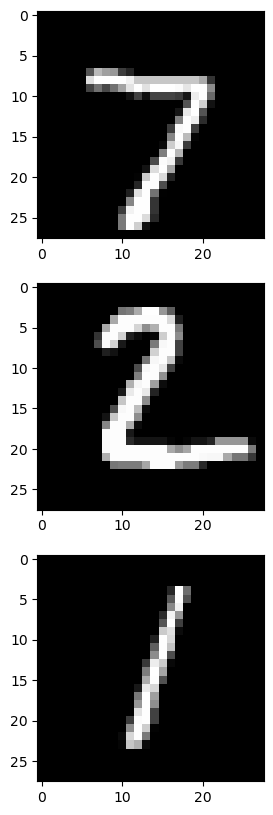

In [152]:
fig,axes = plt.subplots(len(test_input_arr),1,figsize=(10,10))
for i in range(len(test_input_arr)):
    img = test_input_arr[i]
    img = img.reshape(28,28)
    axes[i].imshow(img,'gray')

plt.show()
    

In [153]:
# API 테스트
runner = bentoml.mlflow.get("mnist_clf:latest").to_runner()
runner.init_local()
result = runner.predict.run(test_input_arr)

for i in result:
    print(np.argmax(i))

'Runner.init_local' is for debugging and testing only.


7
2
1


In [ ]:
!bentoml serve service:svc --reload

2022-11-09T14:33:14+0900 [INFO] [cli] Prometheus metrics for HTTP BentoServer from "service:svc" can be accessed at http://localhost:3000/metrics.
2022-11-09T14:33:14+0900 [INFO] [cli] Starting development HTTP BentoServer from "service:svc" running on http://0.0.0.0:3000 (Press CTRL+C to quit)
2022-11-09 14:33:15 circus[2490151] [INFO] Loading the plugin...
2022-11-09 14:33:15 circus[2490151] [INFO] Endpoint: 'tcp://127.0.0.1:48079'
2022-11-09 14:33:15 circus[2490151] [INFO] Pub/sub: 'tcp://127.0.0.1:47803'
2022-11-09T14:33:15+0900 [INFO] [observer] Watching directories: ['/home/khkim/mlflow_project_practice', '/home/khkim/bentoml/models']
^C
